## Imports and Constants

In [158]:
# Imports
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models, optimizers, layers
from sklearn.manifold import TSNE

# Constants
results_path = '../results/'
models_path = '../models/'
encoder_path = models_path+'encoder'
decoder_path = models_path+'decoder'
autoencoder_path = models_path+'autoencoder'

# Common functions
def dum_loss(a,b):
  return 0

## Load and process the MNIST dataset

In [155]:
(train_images, train_labels), (val_images, val_labels) = mnist.load_data()
train_images = train_images.astype('float32') / 255
val_images = val_images.astype('float32') / 255

# Add a (naive) variation parameter in the targets
def add_var_parameter(dataset):
  ohe = np.zeros((dataset.shape[0], 10)) # The one-hot encoding version of the target
  var = np.zeros((dataset.shape[0], 1)) # The variation parameter
  for i in range(dataset.shape[0]):
    ohe[i, dataset[i]] = 1
    var[i] = i/dataset.shape[0]
  return ohe, var
# Do for each dataset
train_ohe, train_var = add_var_parameter(train_labels)
val_ohe, val_var = add_var_parameter(val_labels)

## Create the autoencoder

### Encoder

In [ ]:
encoder_input = layers.Input(shape = (28, 28, 1), name='Input')
x = layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same', name='Layer1_nt_')(encoder_input)
x = layers.MaxPool2D((2, 2), name='Layer2_nt_')(x)
x = layers.BatchNormalization(name='Layer3_nt_')(x)
x = layers.Conv2D(96, (3, 3), activation='sigmoid', padding='same', name='Layer4_nt_')(x)
x = layers.BatchNormalization(name='Layer5_nt_')(x)
x = layers.MaxPool2D((2, 2), name='Layer6_nt_')(x)
x = layers.Conv2D(128, (3, 3), activation='sigmoid', padding='same', name='Layer7_nt_')(x)
x = layers.BatchNormalization(name='Layer8_nt_')(x)
x = layers.Flatten(name='Layer9')(x)
encoder_out1 = layers.Dense(10, activation='softmax', name='Output1_nt_')(x)
x = layers.Normalization(name='Layer10')(x)
x = layers.Dense(64, activation='sigmoid', name='Layer11')(x)
encoder_out2 = layers.Dense(1, activation='sigmoid', name='Output2')(x)
encoder = models.Model(inputs=encoder_input, outputs=[encoder_out1, encoder_out2])
tf.keras.utils.plot_model(encoder, show_shapes=True, to_file=models_path+'encoder.png')
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 Layer1_nt_ (Conv2D)            (None, 28, 28, 64)   640         ['Input[0][0]']                  
                                                                                                  
 Layer2_nt_ (MaxPooling2D)      (None, 14, 14, 64)   0           ['Layer1_nt_[0][0]']             
                                                                                                  
 Layer3_nt_ (BatchNormalization  (None, 14, 14, 64)  256         ['Layer2_nt_[0][0]']             
 )                                                                                            

In [ ]:
# Compile the encoder
# We use a dummy loss for the first training - we don't care about the variation parameter for now
encoder.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9), loss = {'Output1_nt_': 'categorical_crossentropy', 'Output2': dum_loss}, metrics=['acc'])
# Train it with the training set example and encoded labels
encoder.fit(train_images, [train_ohe, train_var], epochs=3, validation_data=(val_images, [val_ohe, val_var]))

Epoch 1/3
1875/1875 [==============================] - 20s 6ms/step - loss: 0.2644 - Output1_nt__loss: 0.2644 - Output2_loss: 0.0000e+00 - Output1_nt__acc: 0.9599 - Output2_acc: 1.6667e-05 - val_loss: 0.0611 - val_Output1_nt__loss: 0.0611 - val_Output2_loss: 0.0000e+00 - val_Output1_nt__acc: 0.9830 - val_Output2_acc: 1.0000e-04
Epoch 2/3
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0417 - Output1_nt__loss: 0.0417 - Output2_loss: 0.0000e+00 - Output1_nt__acc: 0.9891 - Output2_acc: 1.6667e-05 - val_loss: 0.0380 - val_Output1_nt__loss: 0.0380 - val_Output2_loss: 0.0000e+00 - val_Output1_nt__acc: 0.9886 - val_Output2_acc: 1.0000e-04
Epoch 3/3
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0199 - Output1_nt__loss: 0.0199 - Output2_loss: 0.0000e+00 - Output1_nt__acc: 0.9937 - Output2_acc: 1.6667e-05 - val_loss: 0.0350 - val_Output1_nt__loss: 0.0350 - val_Output2_loss: 0.0000e+00 - val_Output1_nt__acc: 0.9902 - val_Output2_acc: 1.0000e-04


In [ ]:
# Fix encoder weights that correspond to the classifier part
for layer in encoder.layers:
  if '_nt_' in layer.name:
    layer.trainable = False
    print('Fixed weights for {}'.format(layer.name))

Fixed weights for Layer1_nt_
Fixed weights for Layer2_nt_
Fixed weights for Layer3_nt_
Fixed weights for Layer4_nt_
Fixed weights for Layer5_nt_
Fixed weights for Layer6_nt_
Fixed weights for Layer7_nt_
Fixed weights for Layer8_nt_
Fixed weights for Output1_nt_


### Decoder

In [ ]:
decoder_input1 = layers.Input(shape = (10,), name='Input1')
decoder_input2 = layers.Input(shape = (1,), name='Input2')
x = layers.Dense(64, activation='sigmoid', name='Layer1')(decoder_input2)
x = layers.Normalization(name='Layer2')(x)
x = layers.Concatenate(axis=1, name='Layer3')([decoder_input1, x])
x = layers.Dense(7*7*128, activation='sigmoid', name='Layer4')(x)
x = layers.Reshape((7, 7, 128), name='Layer5')(x)
x = layers.BatchNormalization(name='Layer8')(x)
x = layers.Conv2D(96, (3, 3), activation='sigmoid', padding='same', name='Layer9')(x)
x = layers.BatchNormalization(name='Layer10')(x)
x = layers.UpSampling2D((2, 2), name='Layer11')(x)
x = layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same', name='Layer12')(x)
x = layers.BatchNormalization(name='Layer13')(x)
x = layers.UpSampling2D((2, 2), name='Layer14')(x)
x = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='Layer15')(x)
x = layers.Reshape((28, 28), name='Output')(x)
decoder = models.Model(inputs=[decoder_input1, decoder_input2], outputs=x)
tf.keras.utils.plot_model(decoder, show_shapes=True, to_file=models_path+'decoder.png')
decoder.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input2 (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 Layer1 (Dense)                 (None, 64)           128         ['Input2[0][0]']                 
                                                                                                  
 Input1 (InputLayer)            [(None, 10)]         0           []                               
                                                                                                  
 Layer2 (Normalization)         (None, 64)           129         ['Layer1[0][0]']                 
                                                                                            

In [ ]:
# Compile the decoder
decoder.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss = "binary_crossentropy")
# For performance purposes, we can train the decoder a few iterations so that the weights are already initialized in a good way (Uncomment to test)
# decoder.fit([train_ohe, train_var], train_images, batch_size=512, epochs=5, validation_data=([val_ohe, val_var], val_images))

Epoch 1/5
118/118 [==============================] - 5s 22ms/step - loss: 0.5276 - val_loss: 0.4213
Epoch 2/5
118/118 [==============================] - 2s 19ms/step - loss: 0.4398 - val_loss: 0.4155
Epoch 3/5
118/118 [==============================] - 2s 19ms/step - loss: 0.3789 - val_loss: 0.3711
Epoch 4/5
118/118 [==============================] - 2s 19ms/step - loss: 0.3134 - val_loss: 0.3109
Epoch 5/5
118/118 [==============================] - 2s 19ms/step - loss: 0.2696 - val_loss: 0.2705


### Training the whole Autoencoder

In [ ]:
ae_input = layers.Input(shape = (28, 28))
latent_vector = encoder(ae_input)
ae_output = decoder(latent_vector)
autoencoder = models.Model(inputs = ae_input , outputs = ae_output)
tf.keras.utils.plot_model(autoencoder, show_shapes=True, to_file=models_path+'autoencoder.png')
autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 model (Functional)             [(None, 10),         644716      ['input_1[0][0]']                
                                 (None, 1)]                                                       
                                                                                                  
 model_1 (Functional)           (None, 28, 28)       638434      ['model[0][0]',                  
                                                                  'model[0][1]']                  
                                                                                            

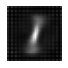

EPOCH - 0
938/938 [==============================] - 9s 8ms/step - loss: 0.2209 - val_loss: 0.2114


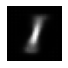

EPOCH - 1
938/938 [==============================] - 7s 7ms/step - loss: 0.2066 - val_loss: 0.2023


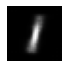

EPOCH - 2
938/938 [==============================] - 7s 7ms/step - loss: 0.1965 - val_loss: 0.1922


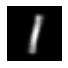

EPOCH - 3
938/938 [==============================] - 7s 7ms/step - loss: 0.1913 - val_loss: 0.1893


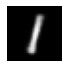

EPOCH - 4
938/938 [==============================] - 7s 7ms/step - loss: 0.1885 - val_loss: 0.1883


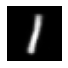

EPOCH - 5
938/938 [==============================] - 7s 7ms/step - loss: 0.1870 - val_loss: 0.1858


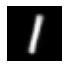

EPOCH - 6
938/938 [==============================] - 7s 7ms/step - loss: 0.1860 - val_loss: 0.1855


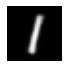

EPOCH - 7
938/938 [==============================] - 7s 7ms/step - loss: 0.1852 - val_loss: 0.1843


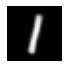

EPOCH - 8
938/938 [==============================] - 7s 7ms/step - loss: 0.1847 - val_loss: 0.1849


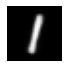

EPOCH - 9
938/938 [==============================] - 7s 7ms/step - loss: 0.1840 - val_loss: 0.1831


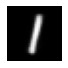

EPOCH - 10
938/938 [==============================] - 7s 7ms/step - loss: 0.1836 - val_loss: 0.1839


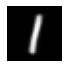

EPOCH - 11
938/938 [==============================] - 7s 7ms/step - loss: 0.1831 - val_loss: 0.1826


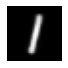

EPOCH - 12
938/938 [==============================] - 7s 8ms/step - loss: 0.1829 - val_loss: 0.1829


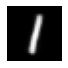

EPOCH - 13
938/938 [==============================] - 7s 7ms/step - loss: 0.1824 - val_loss: 0.1820


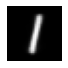

EPOCH - 14
938/938 [==============================] - 7s 7ms/step - loss: 0.1822 - val_loss: 0.1824


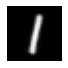

EPOCH - 15
938/938 [==============================] - 7s 7ms/step - loss: 0.1819 - val_loss: 0.1821


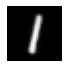

EPOCH - 16
938/938 [==============================] - 7s 7ms/step - loss: 0.1815 - val_loss: 0.1818


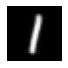

EPOCH - 17
938/938 [==============================] - 7s 7ms/step - loss: 0.1813 - val_loss: 0.1824


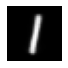

EPOCH - 18
938/938 [==============================] - 7s 7ms/step - loss: 0.1811 - val_loss: 0.1816


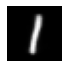

EPOCH - 19
938/938 [==============================] - 7s 8ms/step - loss: 0.1809 - val_loss: 0.1816


In [ ]:
def decode_example():
  ohe = np.zeros((1, 10)) # One hot encoded vector init
  ohe[0, 1] = 1 # Choos the number 1
  var = np.zeros((1, 1)) # Variation parameter init
  var[0] = 0.5 # Random ratio
  image = decoder.predict([ohe, var])[0]
  plt.rcParams["figure.figsize"] = (1,1)
  plt.imshow(image, cmap = "gray")
  plt.axis('off')
  plt.show()
# Compile the autoencoder
autoencoder.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss = "binary_crossentropy")
# Train the whole autoencoder
for i in range(20):
  decode_example()
  # We train one iteration by one to see the changes
  print(f'EPOCH - {i}')
  autoencoder.fit(train_images, train_images, batch_size=64, epochs=1, validation_data=[val_images, val_images])

### Saving the model weights

In [ ]:
encoder.save(encoder_path)
decoder.save(decoder_path)
autoencoder.save(autoencoder_path)

## Results

### Downloading sample results

In [ ]:
!wget "https://jeanhaberer.com/cs512/project/results.zip" -O ../results.zip
!unzip ../results.zip -d ..
!rm ../results.zip

--2022-04-18 17:53:23--  https://jeanhaberer.com/cs512/project/results.zip
Resolving jeanhaberer.com (jeanhaberer.com)... 87.98.154.146, 2001:41d0:301::26
Connecting to jeanhaberer.com (jeanhaberer.com)|87.98.154.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25537609 (24M) [application/zip]
Saving to: ‘../results.zip’

../results.zip      100%[===================>]  24.35M  14.3MB/s    in 1.7s    

2022-04-18 17:53:26 (14.3 MB/s) - ‘../results.zip’ saved [25537609/25537609]

Archive:  ../results.zip
   creating: ../results/
  inflating: ../results/RandomTransformations.mp4  
  inflating: ../results/Number2Number.mp4  
  inflating: ../results/NumberTransormationsVSVariations.png  


### Loading the models

In [ ]:
# Download the models from the server if needed
!wget "https://jeanhaberer.com/cs512/project/models.zip" -O ../models.zip
!unzip ../models.zip -d ..
!rm ../models.zip

In [156]:
# Load the models
encoder = tf.keras.models.load_model(encoder_path, custom_objects={'dum_loss': dum_loss})
decoder = tf.keras.models.load_model(decoder_path)
autoencoder = tf.keras.models.load_model(autoencoder_path)

### LIVE TESTING - Testing the model

#### Encoder results
##### Sample testing

In [ ]:
def pretty_print_vector(vector):
    l =  "––––––––––"
    l1 = "  INDEX | " 
    l2 = "  VALUE | "
    for i in range(len(vector)):
        l1 +=  "   {}   |".format(i)
        l +=   "––––––––"
        l2 +=  " {:.03f} |".format(vector[i])
    print(l)
    print(l1)
    print(l)
    print(l2)
    print(l)

def print_latent_space(number):
    assert(number >= 0 and number <= 9)
    random_index = np.random.choice([i for i in range(len(val_labels)) if val_labels[i] == number])
    image = val_images[random_index]
    print("LATENT SPACE FOR IMAGE:")
    plt.imshow(image, cmap = "gray")
    plt.axis('off')
    plt.show()
    latent_space = encoder.predict(np.array([image]))
    print("––––––––––––––––")
    print("VARIATION: {:.03f}".format(latent_space[1][0][0]))
    print("––––––––––––––––")
    print("NUMBER VECTOR:")
    pretty_print_vector(latent_space[0][0])


LATENT SPACE FOR IMAGE:


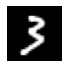

––––––––––––––––
VARIATION: 0.445
––––––––––––––––
NUMBER VECTOR:
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
  INDEX |    0   |   1   |   2   |   3   |   4   |   5   |   6   |   7   |   8   |   9   |
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
  VALUE |  0.000 | 0.000 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 |
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––


In [ ]:
# Try it out HERE!
print_latent_space(3)

#### Decoder Results

##### Sample Testing

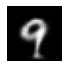

In [ ]:
# Try it out HERE!
# We can actually observe here that not respecting the probabilstic model encoding (sum of parameter = 1) results in getting better generated images.
# For example here, we put 2 in the 9th component instead of 1.

ohe_vector = np.array(
    [ 
        0, # Component for 0 
        0, # Component for 1
        0, # Component for 2 
        0, # Component for 3 
        0, # Component for 4 
        0, # Component for 5 
        0, # Component for 6 
        0, # Component for 7 
        0, # Component for 8 
        2  # Component for 9 
    ]
)
var = 0.5

generated_image = decoder.predict([np.array([ohe_vector]), np.array([var])])[0]
plt.imshow(generated_image, cmap = "gray")
plt.axis('off')
plt.show()

##### Visualizing different variation in a number

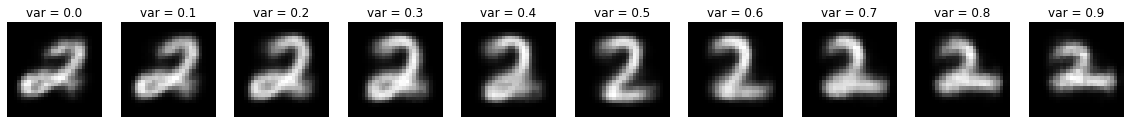

In [ ]:
n = 2 # Choose the number to display

plt.figure(figsize=(20,3))
for i in range(10):
    ohe = np.zeros((1, 10)) # One hot encoded vector init
    ohe[0, n] = 1 # Choose the number 1
    var = np.zeros((1, 1)) # Variation parameter init
    var[0] = (i/10)%1 # Random ratio
    image = decoder.predict([ohe, var])[0]
    plt.subplot(1, 10, i+1)
    plt.imshow(image, cmap = "gray")
    plt.title("var = " + str((i/10)%1))
    plt.axis('off')
plt.savefig(results_path+f'{n}_variations.png', dpi=500, bbox_inches = "tight")
plt.show()

##### Visualizing a transition from a number to another

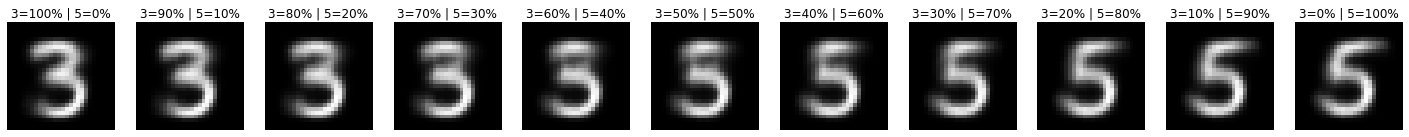

In [ ]:
n1 = 3 # Choose the number 1 to display
n2 = 5 # Choose the number 2 to display

plt.figure(figsize=(25,3))
for i in range(0,11):
    ohe = np.zeros((1, 10)) # One hot encoded vector init
    ohe[0, n1] = 1-(i/10) # Choose the number 1
    ohe[0, n2] = (i/10) # Choose the number 2
    var = np.zeros((1, 1)) # Variation parameter init
    var[0] = 0.6 # Random ratio
    image = decoder.predict([ohe, var])[0]
    plt.subplot(1, 11, i+1)
    plt.imshow(image, cmap = "gray")
    plt.axis('off')
    plt.title( "3={:.0f}%".format((1-(i/10))*100)+" | 5={:.0f}%".format(i/10*100) )
plt.savefig(results_path+f'/{n1}_{n2}_transition_var_{var[0]}.png', dpi=500, bbox_inches = "tight")
plt.show()

### VIDEO - Transitions from number to number for multiple variations

In [55]:
# 1. Generate the frames
frames = 60 # Number of frames per number
col = 32 # Number of variations (vertically)
row = 32 # Number of variations (horizontally)
nb_of_var = col*row # Total number of variations
# Initialize the input vectors
images_ohe = np.zeros((frames*10*nb_of_var, 10)) # 'One hot encoding' vectors
images_var = np.zeros((frames*10*nb_of_var, 1)) # Variation vector
amplificator_ratio = 1 # Multiplies the latent space vector by this factor

for i in range(images_var.shape[0]):
  images_var[i] = (i/nb_of_var)%1 # For each frame, compute the variation parameter (from 0 (top left corner) to 1 (bottom right corner))

for n in range(10): # For each number
  for i in range(frames): # For each frame per number
    for v in range(nb_of_var): # For each variation
      progress = i/frames # Compute the progress of the transition
      progress = (np.tanh(4*(progress-0.5))+1)/2 # Curve the progress (ease in - ease out)
      image_i = (n*frames+i)*nb_of_var + v # Compute the index of the frame
      images_ohe[image_i, n%10] = (1 - progress)*amplificator_ratio # Add the value for the current number in the OHE vector of the frame
      images_ohe[image_i, (n+1)%10] = (progress)*amplificator_ratio # Add the value for the next number in the OHE vector of the frame

images = decoder.predict([images_ohe, images_var]) # Decode each frame with the decoder
images = images.reshape((frames*10, row, col, 28, 28)) # Reshape the images matrix

# 2. Create the video
video_name = results_path+'Number2Number.mp4' # Video path
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MP4V'), 25, (28*row,28*col))
for f in range(images.shape[0]): # For each frame
  im = np.zeros((28*row, 28*col, 3)) # Create a zero matrix
  for r in range(images.shape[1]): # For each row
    for c in range(images.shape[2]): # For each column
      # Draw the image in the matrix
      im[r*28:r*28+28,c*28:c*28+28, 0] = images[f, r, c]*255
      im[r*28:r*28+28,c*28:c*28+28, 1] = images[f, r, c]*255
      im[r*28:r*28+28,c*28:c*28+28, 2] = images[f, r, c]*255
  # Write the frame in the video
  video.write(im.astype('uint8'))
# Save the video
cv2.destroyAllWindows()
video.release()

### VIDEO - Transitions from number to random number along with continuous variation changes

In [56]:
# 1. Generate frames
number_transition_frames = 80 # Number of frame for each number transition
variation_transition_frames = 130 # Number of frame for a whole variation transition (from 0 to 1 - or 1 to 0)
number_transitions = 64 # Number of transitions to complete
total_frames = (number_transition_frames)*number_transitions # Compute the total number of frames
images_ohe = np.zeros((total_frames, 10)) # 'One hot encoding' vectors
images_var = np.zeros((total_frames, 1)) # Variation vector
amplificator_ratio = 1 # Multiplies the latent space vector by this factor

current_n = 0 # Current number
image_i = 0 # Current frame index
for nt in range(number_transitions):
  last_n = current_n
  # Chose a different number randomly
  while current_n == last_n:
    current_n = np.random.random_integers(0, 9)
  # Do a transition to this new number
  for ntf in range(number_transition_frames): # For each transition frame
    progress = ntf/number_transition_frames # Compute the transition progress
    progress = (np.tanh(10*(progress-0.5))+1)/2 # Curve the transition (ease in - ease out)
    images_ohe[image_i, last_n%10] = (1 - progress)*amplificator_ratio # Add the value for the current number in the OHE vector of the frame
    images_ohe[image_i, current_n%10] = (progress)*amplificator_ratio # Add the value for the next number in the OHE vector of the frame
    images_var[image_i] = (np.cos(image_i/variation_transition_frames*np.pi)+1)/2 # Add the variation parameter (cosinusoide curve from 0 to 1 and 1 to 0)
    image_i+=1

images = decoder.predict([images_ohe, images_var]) # Decode each frame with the decoder

# 2. Create the video
# Create an information header
header_height = 32
bar_height = 6
space = 8
frame_size = 512
# Create the video file
video_name = results_path+'RandomTransformations.mp4' # Video path
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MP4V'), 25, (frame_size,frame_size+header_height))

for f in range(total_frames): # For each frame
  im = np.zeros((28, 28, 3)) # Create the number image matrix
  # Draw the image in the matrix
  im[:,:, 0] = images[f]*255
  im[:,:, 1] = images[f]*255
  im[:,:, 2] = images[f]*255
  # Create the frame matrix
  out = np.zeros((frame_size+header_height,frame_size, 3))
  # Resize the number image
  resized = cv2.resize(im, (frame_size, frame_size), fx=0,fy=0, interpolation = cv2.INTER_LINEAR)
  # Fill the frame with the image
  out[header_height:, :, :] = resized
  # Add the information header
  max_y = lambda x: space + int((x)*(frame_size - space*2))
  var_max_y = max_y(images_var[f])
  num_max_y = max_y(sum(images_ohe[f]*[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])/9)
  out[space:space+bar_height, space:var_max_y, 0] = 255
  out[2*space+bar_height:2*space+2*bar_height, space:num_max_y, 2] = 255
  # Write the frame
  video.write(out.astype('uint8'))
# Save the video
cv2.destroyAllWindows()
video.release()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: This function is deprecated. Please call randint(0, 9 + 1) instead
  app.launch_new_instance()


### IMAGE - Transformation between ordered numbers VS variation transformations

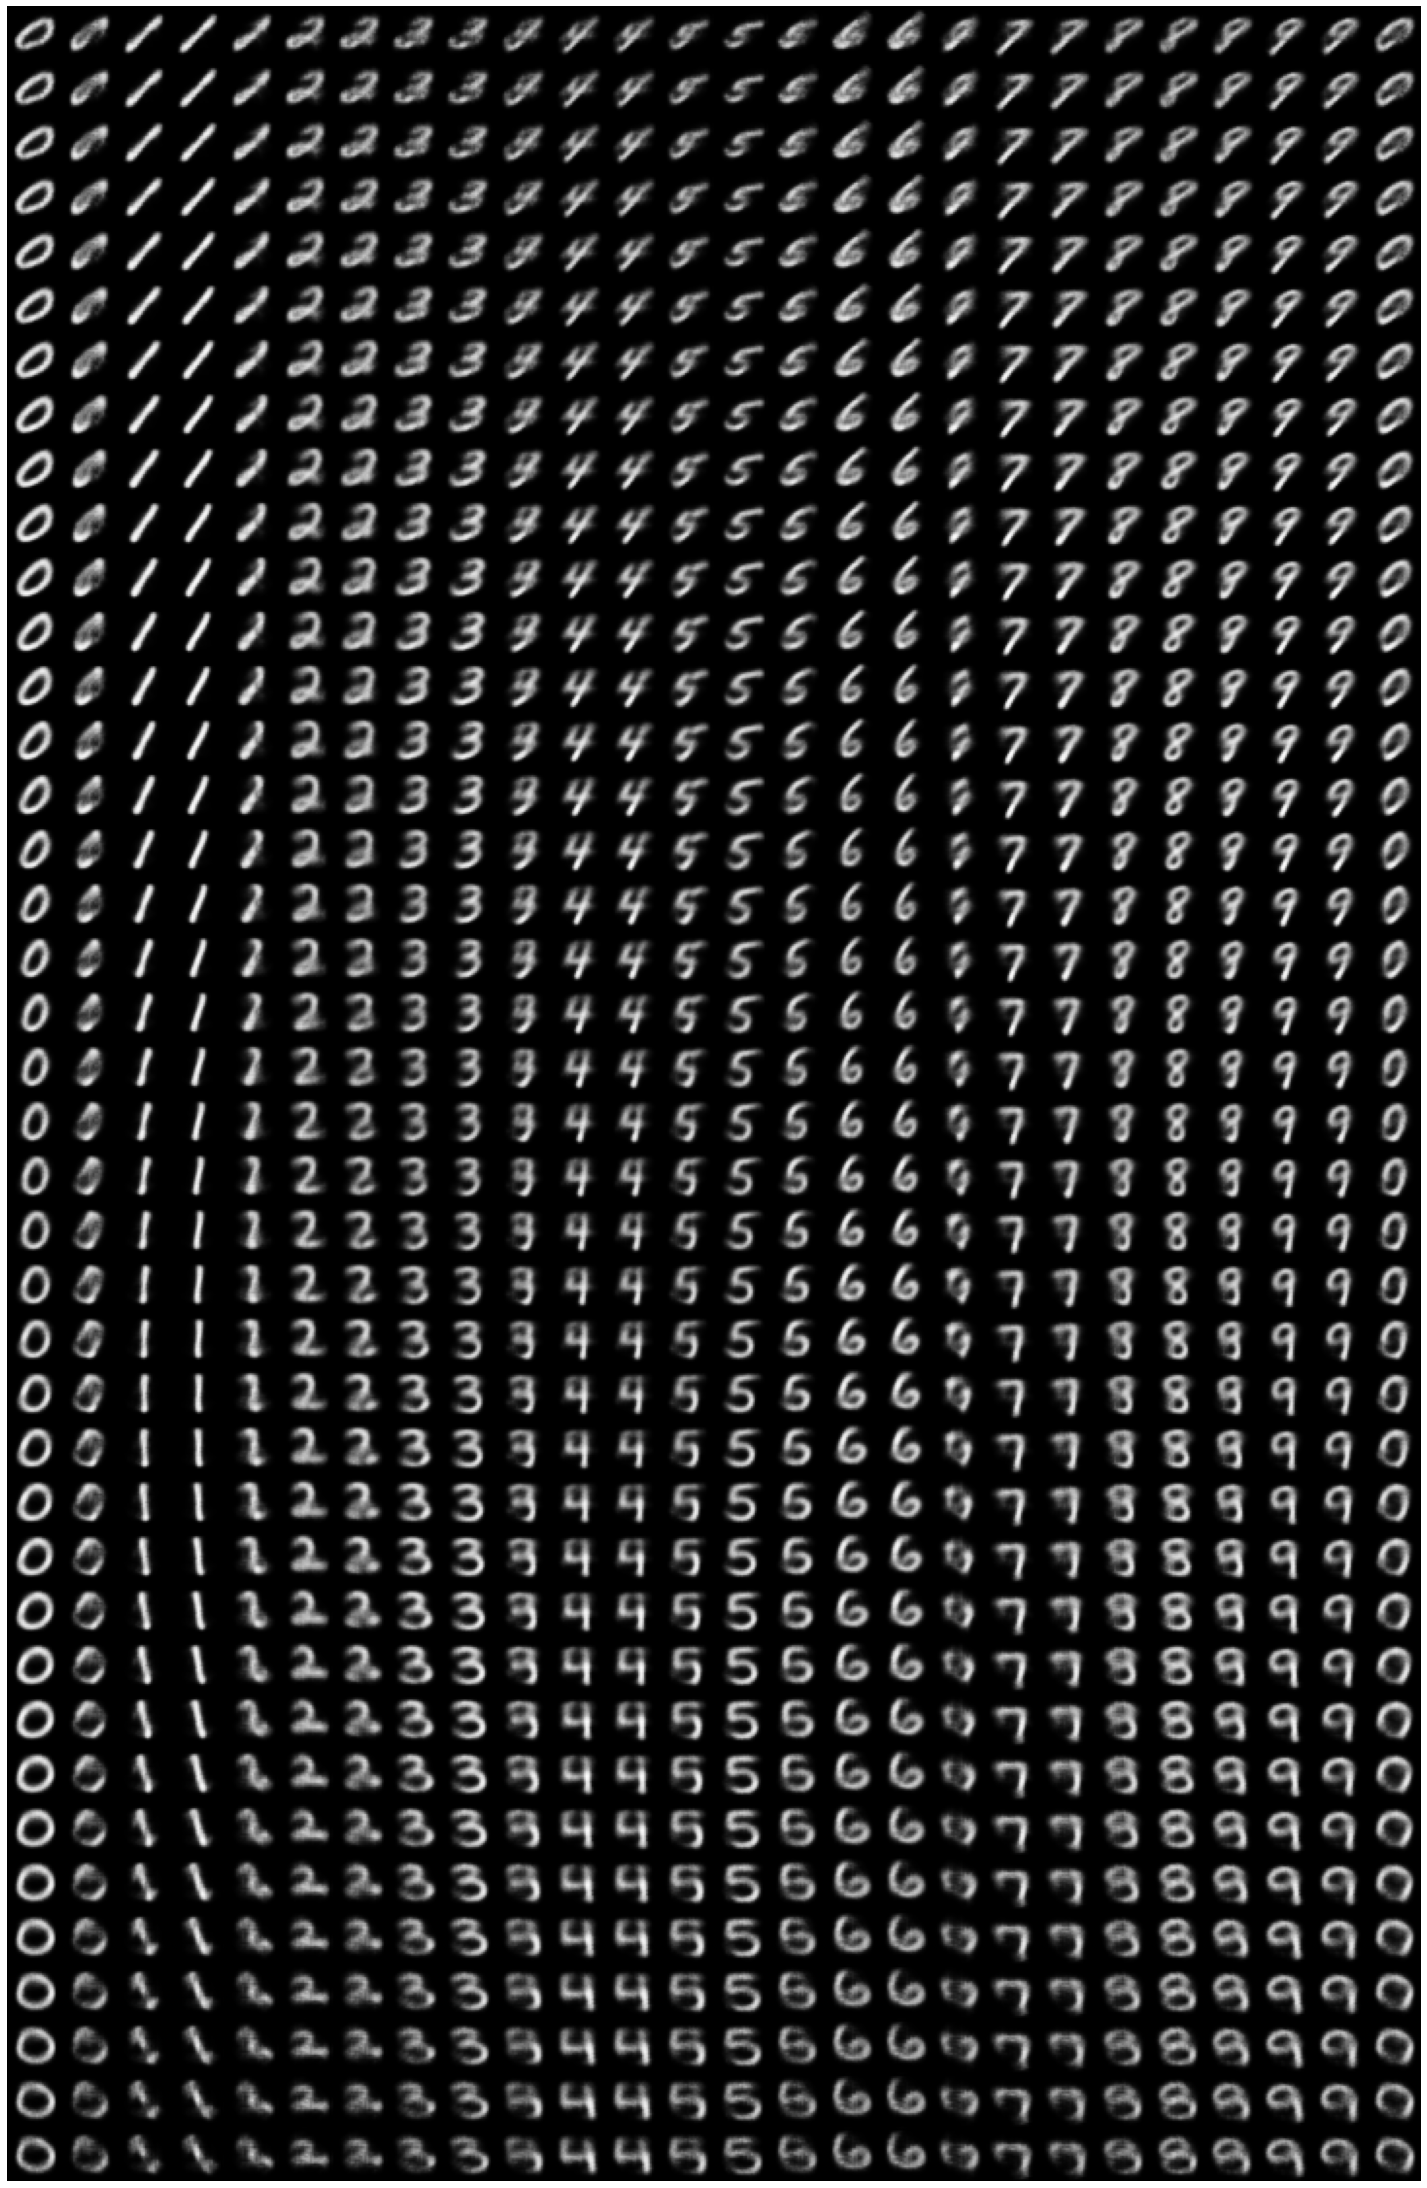

In [57]:
# 1. Generate the images
# Image parameters
col = 26
row = 40
nb_of_var = col*row
amplificator_ratio = 1 # Multiplies the latent space vector by this factor

# Generate the images
images_ohe = np.zeros((nb_of_var, 10))
images_var = np.zeros((nb_of_var, 1))
for i in range(nb_of_var):
  images_var[i] = (i/row)%1 # Compute the variation parameter for each number (0 to 1 from the top to the bottom of the image)

for r in range(row): # For each row
  for c in range(col): # For each column
    progress = c/col * 10.0 # At what number we are, from 0 to 9
    n = int(progress) # Compute the actual integer
    image_i = c*row + r # Compute the image index
    images_ohe[image_i, n%10] = (1 - (progress - n))*amplificator_ratio # Compute the OHE participation for n
    images_ohe[image_i, (n+1)%10] = ((progress - n))*amplificator_ratio # Compute the OHE participation for n+1

images = decoder.predict([images_ohe, images_var]) # Use the decoder to generate the images
images = images.reshape((col, row, 28, 28)) # Reshape the images imatrix

# 2. Plot the images
im = np.zeros((28*row, 28*col)) # Initialize the matrix
for c in range(col): # For each column
  for r in range(row): # For each row
    im[r*28:r*28+28,c*28:c*28+28] = images[c, r] # Add the image at the right position
# Show and save the figure
plt.rcParams["figure.figsize"] = (col,row)
plt.imshow(im, cmap = "gray")
plt.axis("off")
plt.savefig(results_path+'NumberTransormationsVSVariations.png', bbox_inches='tight', pad_inches=0)
plt.show()

### CLUSTER - Vizualization of the clusters in the latent space

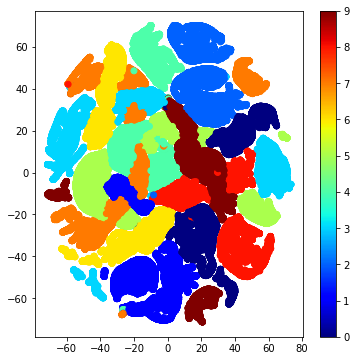

In [159]:
predicted = encoder.predict(train_images, batch_size=32)
tsne = TSNE(n_components=2, init='random')

X_embedded = tsne.fit_transform(predicted[0])
plt.figure(figsize=(6, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=train_labels, cmap=plt.get_cmap("jet"))
plt.colorbar()
plt.savefig(results_path+f'/tsne_.png', dpi=500, bbox_inches = "tight")
plt.show()